![title](wikipedia-logo.webp)

In this project we will do some analysis on the wikipedia hyperlink graph, first of all let's create the graph using the edge list contained in the file `wikigraph_reduced.csv`.

In [1]:
from graph import *

g = Graph()
g.create_from_file()

Then we load the categories obtained through a preprocessing of the original file `wiki-topcats-categories.txt` where each page belong to different categories is reduced to a single category picked u.a.r. This can be seen as labels of each node, and will then be used for further analysis.

In [2]:
# Run this cell to create the file `reduced_categories.txt`
from utils import categories_preprocess

categories_preprocess()

In [3]:
# this loads the labels into the graph
g.load_categories()

### RQ 1

We first explore a few properties of the graph.

In [4]:
print("Graph directed?", g.is_directed())

Graph directed? True


In [5]:
print("Number of nodes:", g.node_count())

Number of nodes: 98343


In [6]:
print("Number of hyperlinks between pages:", g.edge_count())

Number of hyperlinks between pages: 483094


In [7]:
print("Average number of outlinks: {:.1f}".format(g.avg_num_links()))

Average number of outlinks: 4.9


In [8]:
print("Graph density:", g.density())

Graph density: 4.9951571365597335e-05


The graph is definitely sparse as on average a node only has 5 neighbours, a very small number compared to the total number of nodes as can also be seen by the very small value of density.

The graph a typical behaviour of social graphs, its (out)degree distribution follows a power law as can be seen by the log-log graph below.

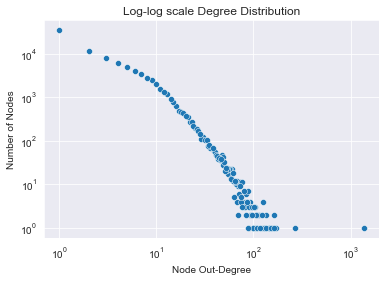

In [9]:
g.plot_degree_distribution()

### RQ 2

To know which node is reachable starting from a specific root within a certain number of steps (distance) we can use a standard Breadth First Search (BFS) with an early stop condition when the maximum distance of interested is reached.

In [10]:
root = 173  # starting node label
dist = 5  # distance
print("Starting from {} with degree {}".format(root, g.out_degree(root)))
reachable_nodes = g.truncated_bfs(root, dist)
print("Found {} nodes at dist <= {}".format(len(reachable_nodes), dist))
print("Just a few: ", reachable_nodes[:5])

Starting from 173 with degree 11
Found 35251 nodes at dist <= 5
Just a few:  [174, 146870, 1059766, 1059906, 1060905]


### RQ 3

We're now interested to find the number of clicks (distance) required to reach a group of pages within a category starting from its central node.

Let's first find a few category for which the central node has a non-zero degree.

In [11]:
for cat_str in g.categories_list()[:10]:
    cat_id = g.get_category_id(cat_str)
    central_node = g.central_node(cat_id)
    if g.out_degree(central_node) > 0:
        print("{} has a central node of non-zero degree".format(cat_id))

2 has a central node of non-zero degree
3 has a central node of non-zero degree
5 has a central node of non-zero degree
6 has a central node of non-zero degree
7 has a central node of non-zero degree
8 has a central node of non-zero degree
9 has a central node of non-zero degree


These are the nodes reachable within 5 clicks from the central node.

In [19]:
cat_id = 9
root = g.central_node(cat_id)
dist = 6
reachable_nodes = g.truncated_bfs(root, dist)
print("Found {} nodes at distance {} from {}".format(len(reachable_nodes),
                                                     dist, root))

Found 51296 nodes at distance 6 from 1062622


Let's now reduce these to the ones in the same category of the central node.

In [20]:
nodes_in_cat = list(filter(lambda x: g.get_node_category(x) == cat_id,
                           reachable_nodes))
print("Reduced to {} in category {}".format(len(nodes_in_cat), cat_id))

Reduced to 2588 in category 9


Now let's take a few random nodes among those and see how much it takes to reach them. We repeat this a few times to show different results for different samples.

In [21]:
from random import sample

size = 10
n_sim = 10

for _ in range(n_sim):
    sample_nodes = sample(nodes_in_cat, size)
    dist = g.get_category_distance(cat_id, sample_nodes)
    if dist < 0:
        print("Target nodes could not be reached.")
    else:
        print("Nodes reached within {} clicks.".format(dist))

Nodes reached within 5 clicks.
Nodes reached within 4 clicks.
Nodes reached within 6 clicks.
Nodes reached within 6 clicks.
Nodes reached within 5 clicks.
Nodes reached within 6 clicks.
Nodes reached within 6 clicks.
Nodes reached within 6 clicks.
Nodes reached within 6 clicks.
Nodes reached within 5 clicks.


As expected 6 clicks will always be enough but sometimes it takes less, as in fact here we stop when we reach the target nodes while before we were stopping at a specific distance.

### RQ 4

In [23]:
# uncomment the following lines to print pair of categories
# that result in decently sidzed subgraphs
# cat_size = 1000
# n_edges = 100
# small_categories = list(map(g.get_category_id, g.get_small_categories(size=1000)))

# count = 0
# for cat_id_1 in small_categories:
#     for cat_id_2 in small_categories:
#         m = g.induced_subgraph(cat_id_1, cat_id_2).edge_count()
#         if m > n_edges:
#             print("E({},{}) = {}".format(cat_id_1, cat_id_2, m))

# this is a sample output obtained
# E(0,1166) = 106
# E(0,2954) = 808
# E(0,2955) = 186
# E(0,3120) = 122
# E(0,3977) = 194

Let's use categories 0 and 2384 that result in a decently large subgraph.

We're then interested in figuring out the size of the minimum cut to disconnect two given nodes in the subgraph.

In [24]:
subgraph = g.induced_subgraph(0, 2954)
node_list = list(subgraph.node_list)
for source, target in zip(node_list[:-1], node_list[1:]):
    size = subgraph.mincut_between_nodes(source, target)
    if size > 0: # we only print mincut for connected nodes
        print("Mincut({}, {}) = {}".format(source, target, size))

Mincut(540720, 540721) = 1
Mincut(536628, 536630) = 3
Mincut(536635, 536636) = 1
Mincut(542865, 542866) = 2
Mincut(542937, 542939) = 2
Mincut(537126, 537128) = 1
Mincut(543281, 543282) = 2
Mincut(139860, 139861) = 2
Mincut(541292, 541293) = 2
Mincut(535279, 535280) = 2
Mincut(1573864, 535538) = 2
Mincut(537600, 537605) = 3
Mincut(543765, 543766) = 2
Mincut(541797, 541798) = 1
Mincut(435302, 435304) = 2
Mincut(537977, 537978) = 2
Mincut(544246, 544247) = 2
Mincut(75328, 75329) = 2
Mincut(542336, 542341) = 2
Mincut(538319, 538320) = 2
Mincut(538460, 538462) = 1
Mincut(538555, 538556) = 2
Mincut(165828, 165829) = 2


The algorithm essentially works by running a modified Depth First Search, where everytime the target is reached the whole recursion path is marked as "visited", since any other possible path to target that has the first few edges in common with the one just found doesn't contain edges of the mincut, we can always cut 1 of the first few common edges to disconnect both paths.

With this in mind it's reasonable that in this subgraph there aren't many disjoint paths between two nodes from different categories.

We can see in fact how the graph has very few edges by plotting it using networkx.

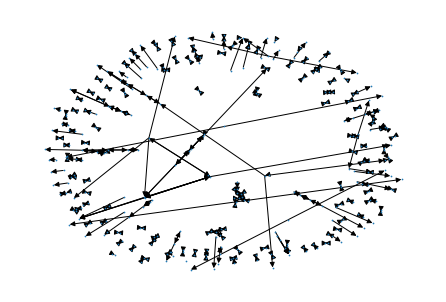

In [27]:
import networkx as nx

nx_g = nx.DiGraph()
nx_g.add_edges_from(subgraph.edge_list)
nx.draw(nx_g, node_size=0.5)

### RQ 5

Next we're interested in the task of sorting categories according to their distance from a specified one, where the distance is computed as the median of distances between all pairs of nodes from the source category to target out. To solve this we create a distance vector from each node of the source category using a BFS, saving distances along the visit, and then computing the median of the distances within each category.

This is not an easy task on a graph of this size, though being sparse we expect the running time of the BFS to be feasible.

In [28]:
g.categories_list()[:10]

['Buprestoidea',
 'Insect_families',
 'Year_of_birth_missing',
 'Alumni_of_New_College,_Oxford',
 'British_radio_personalities',
 'People_from_Worcester',
 'Cheltenham_Town_F.C._players',
 'Yeovil_Town_F.C._players',
 'Worcester_City_F.C._players',
 'Living_people']

Let's pick a category and see the top ten results

In [29]:
cat_str = 'English_footballers'
cat_id = g.get_category_id(cat_str)
closest_list = g.get_closest_categories(cat_id)
closest_list[:10]

100%|██████████████████████████████████████████████████████| 1326/1326 [01:06<00:00, 19.84it/s]


['Scottish_Premier_League_players',
 'Czechoslovak_footballers',
 'People_from_Cape_Town',
 'FIFA_Confederations_Cup-winning_players',
 'Signal_transduction',
 'Association_football_midfielders',
 'Major_League_Baseball_third_basemen',
 'Presidents_of_the_Institution_of_Civil_Engineers',
 'People_of_the_Tudor_period',
 'Olympic_gold_medalists_for_Great_Britain']

### RQ 6

Finally we look at the categories sorted according to their PageRank ranking, to do so we build the adjacency matrix and apply the usual damping factor of 0.85 to compute the normalized matrix M used to iterate over a random initialized vector that will eventually represent the PageRank of each page.

In [30]:
cat_by_pr = g.sort_category_by_pagerank()
cat_by_pr[:10] # top 10 pages

['Living_people',
 'English-language_films',
 'American_films',
 'American_film_actors',
 'American_television_actors',
 'Year_of_birth_missing',
 'Harvard_University_alumni',
 'Year_of_death_missing',
 'Debut_albums',
 'Black-and-white_films']